In [1]:
# a.1) setup path to data-containing folder and savings and parameters
h5ad_path = "/Users/AlexanderWang/Desktop/ics-rebuttal/TE001-h5ad/"
figures_dir = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/"
figures_dir_RNAVeloKernel = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/"
figures_dir_TE001 = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/"
name_prefix = "TE001_"

n_macro_CytoTRACE = 8 # number of macrostates 
scale_data = True

In [2]:
# a.2) packages
import anndata
import sys
import cellrank as cr
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
from scipy.stats import rankdata
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 

In [3]:
# a.3) load counts data (exported from Seurat@RNA assay)
# counts_h5ad = h5ad_path + "TE006-viper.h5ad"
# adata = sc.read_h5ad(counts_h5ad) # load in object

adata = anndata.read_loom(h5ad_path + "TE001.loom")
cell_ids = adata.obs.index.values.copy()
cell_ids = np.array([item.replace('TE001_', '') for item in cell_ids])
cell_ids = np.array([item + '-1' for item in cell_ids])
adata.obs.index = cell_ids
adata.obs['cell_id'] = adata.obs.index

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
pax_data = sc.read_h5ad(h5ad_path + "TE001-subnetworks-one-signature-seurat-viper-analysis-with-metacell-data-with-paneth.h5ad")
specified_columns = ["cell_id", "cytotrace_score.ges", "seurat_clusters", "singleR_labels"]
pax_data.obs = pax_data.obs[specified_columns]

In [5]:
# a.5) process metadata in adata
cells_to_analyze = pax_data.obs['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata
adata.obs = pd.merge(adata.obs, pax_data.obs, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

In [6]:
# a.4) load metadata for TE001 
metadata_csv = h5ad_path + "TE001-metadata-umap-and-clusters-for-paper.csv"
metadata = pd.read_csv(metadata_csv)

In [7]:
cells_to_analyze = metadata['cell_id'] # cells to analyze

In [8]:
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category') # VIPER clusters as categorical variable
adata.obs['seurat_clusters.ges'] = adata.obs['seurat_clusters.ges'].astype('category') # GES clusters as categorical variable

# a.6) set UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1_scanpy','UMAP_2_scanpy']]) 
adata.obsm['X_umap'] = umap_coordinates

# a.7) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

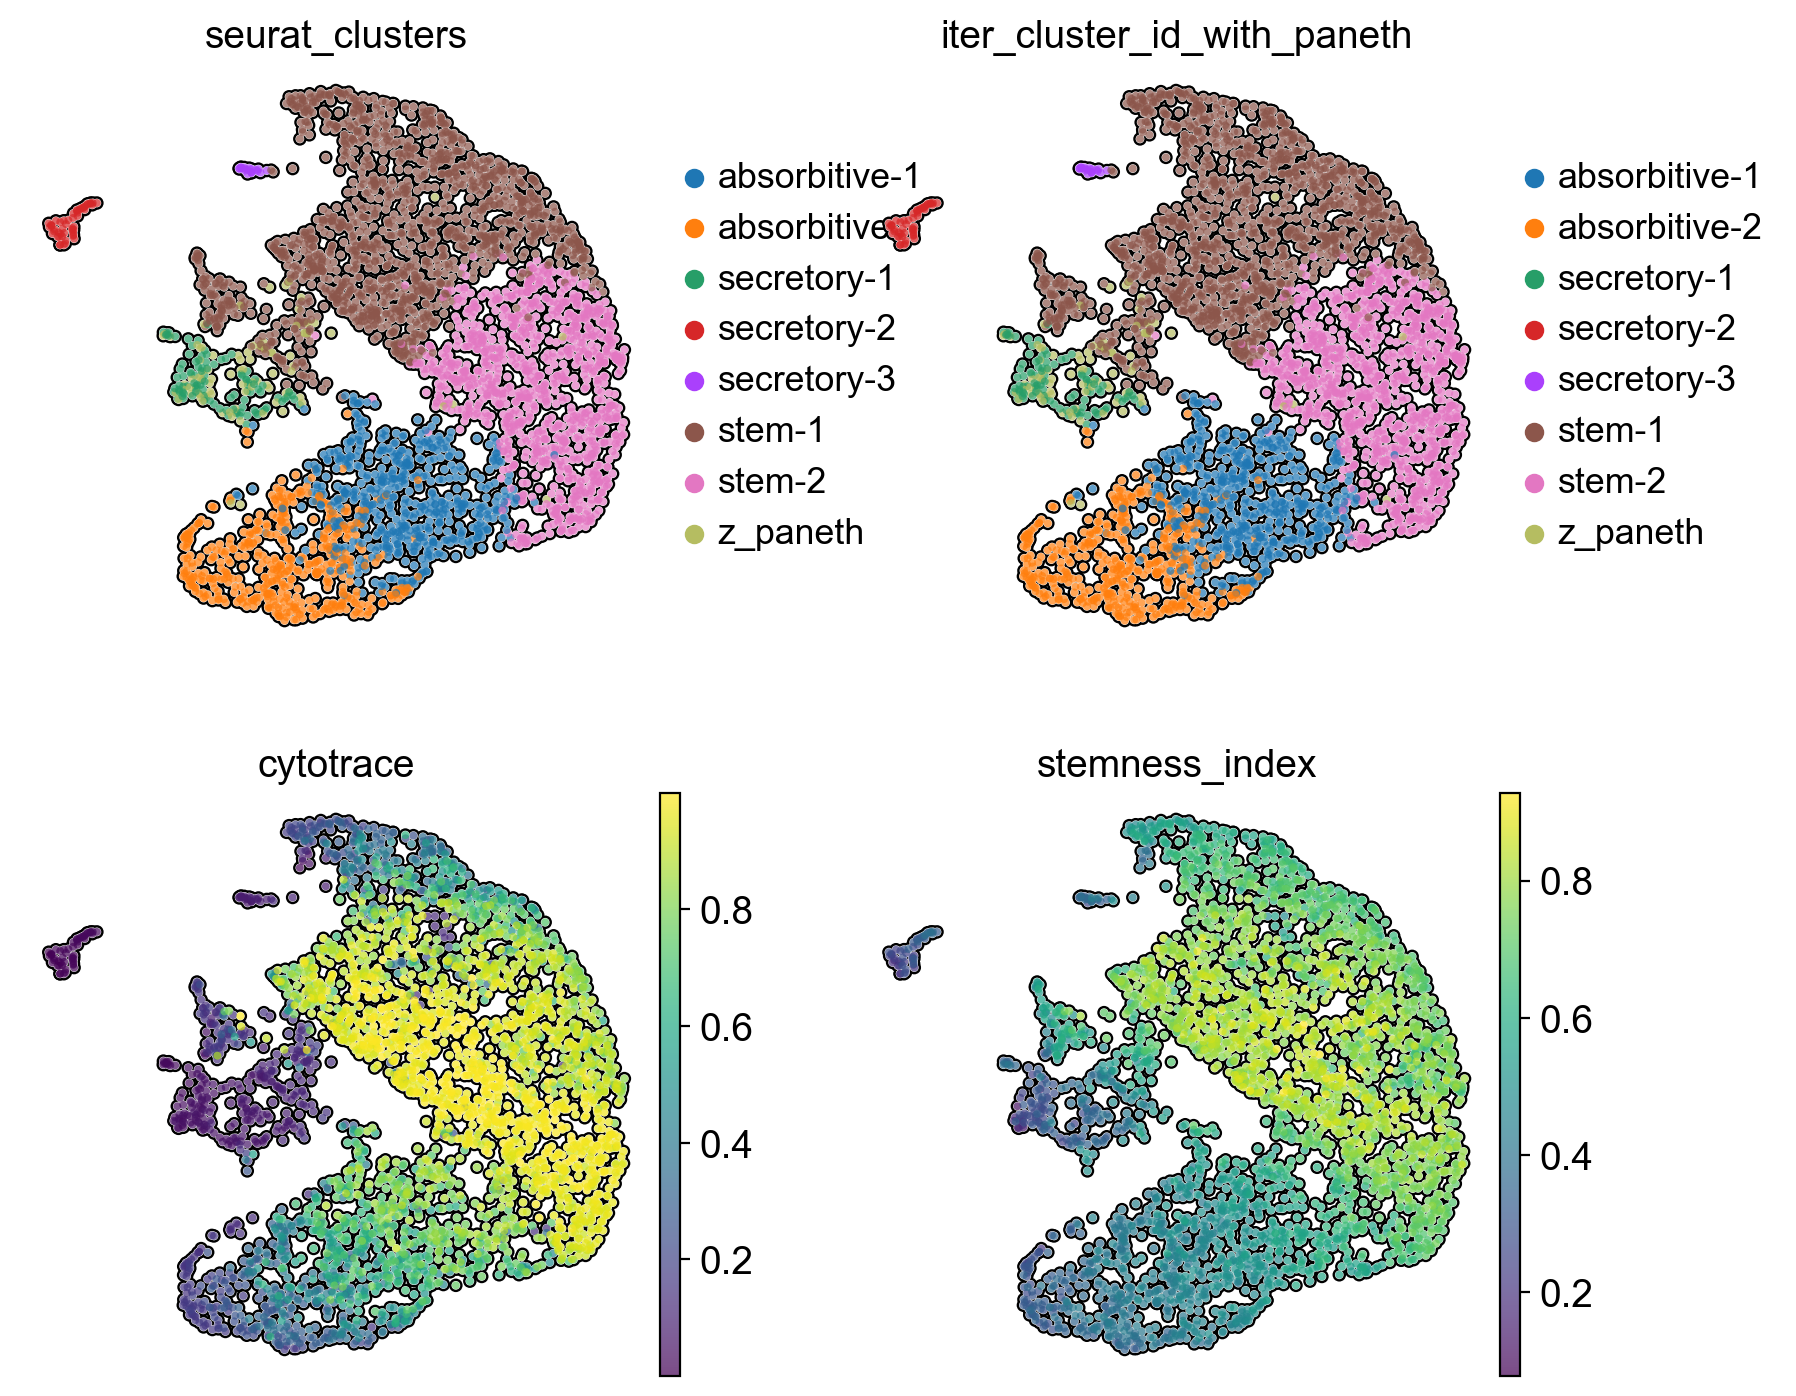

In [9]:
sc.pl.umap(adata, color=["seurat_clusters",'iter_cluster_id_with_paneth',"cytotrace","stemness_index"], ncols=2, add_outline=True)

In [10]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

Filtered out 45999 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/Users/AlexanderWang/opt/miniconda3/envs/cellrank_env_py3_10_osx_arm64/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [11]:
if scale_data:
    adata_scale = anndata.AnnData(adata.X.copy())
    sc.pp.scale(adata_scale)
    adata_scale.to_df()
    sc.tl.pca(adata_scale)
    adata.obsm['X_pca'] = adata_scale.obsm['X_pca'].copy()
    del adata_scale
else:
    sc.tl.pca(adata)

In [12]:
sc.pp.neighbors(adata, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [13]:
scv.tl.recover_dynamics(adata, n_jobs=4)

recovering dynamics (using 4/8 cores)


  0%|          | 0/1567 [00:00<?, ?gene/s]

    finished (0:02:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [14]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [15]:
vk = cr.kernels.VelocityKernel(adata)

In [16]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3656 [00:00<?, ?cell/s]

Using `softmax_scale=4.9597`


  0%|          | 0/3656 [00:00<?, ?cell/s]

    Finish (0:00:11)


VelocityKernel[n=3656, model='deterministic', similarity='correlation', softmax_scale=4.96]

In [17]:
# c.2) Set up figure directories
if os.path.exists(figures_dir):
    print("'figures_dir' directory already exists")
else:
    os.mkdir(figures_dir)

if os.path.exists(figures_dir_RNAVeloKernel):
    print("'figures_dir_VIPERKernel' directory already exists")
else:
    os.mkdir(figures_dir_RNAVeloKernel)

if os.path.exists(figures_dir_TE001):
    print("'figures_dir_TE001' directory already exists")
else:
    os.mkdir(figures_dir_TE001)

'figures_dir' directory already exists
'figures_dir_VIPERKernel' directory already exists


Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_RNAVeloKernel_differentiation_ges_clusters.svg


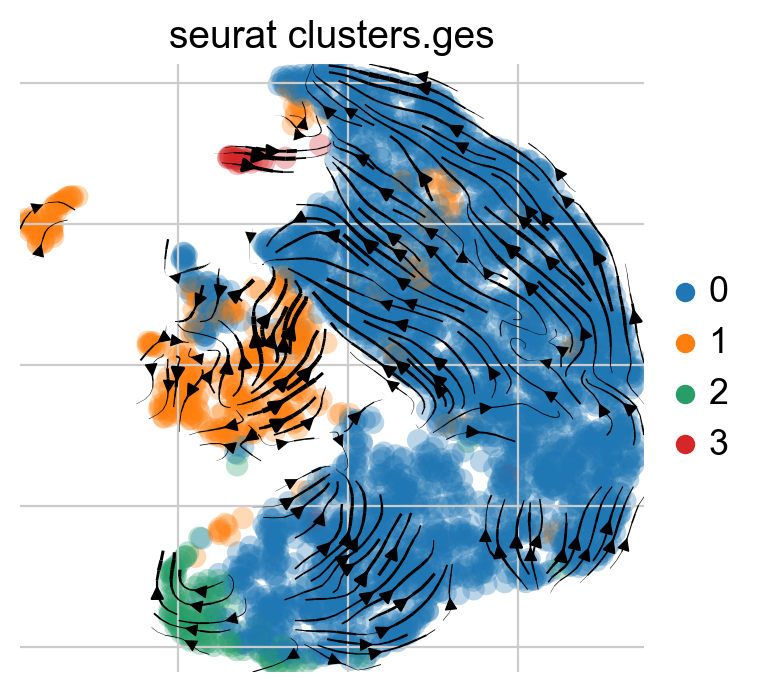

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_RNAVeloKernel_differentiation_pa_clusters.svg


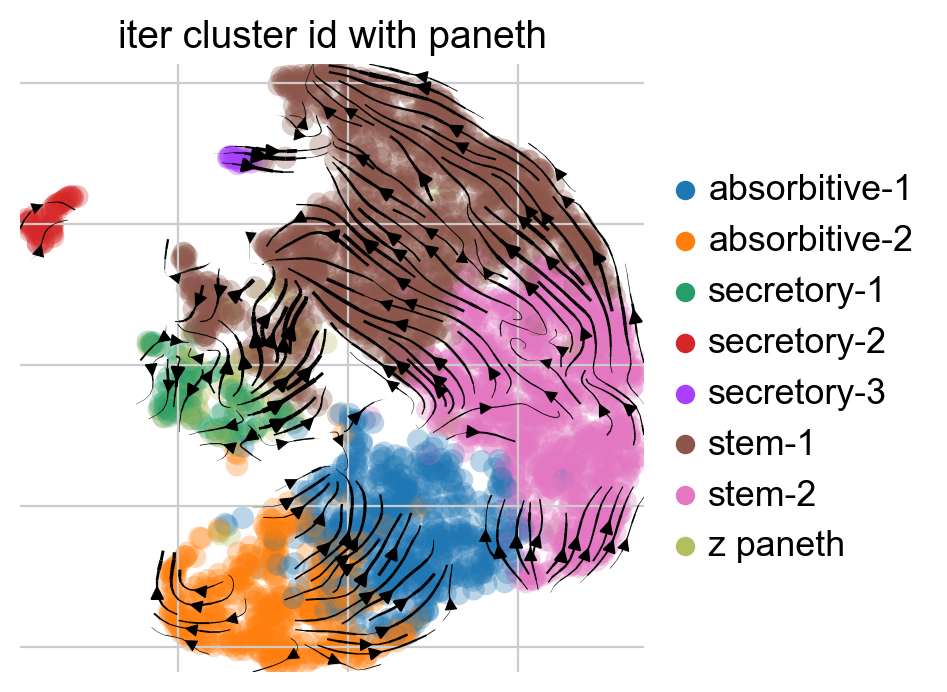

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_RNAVeloKernel_differentiation_cytotrace.svg


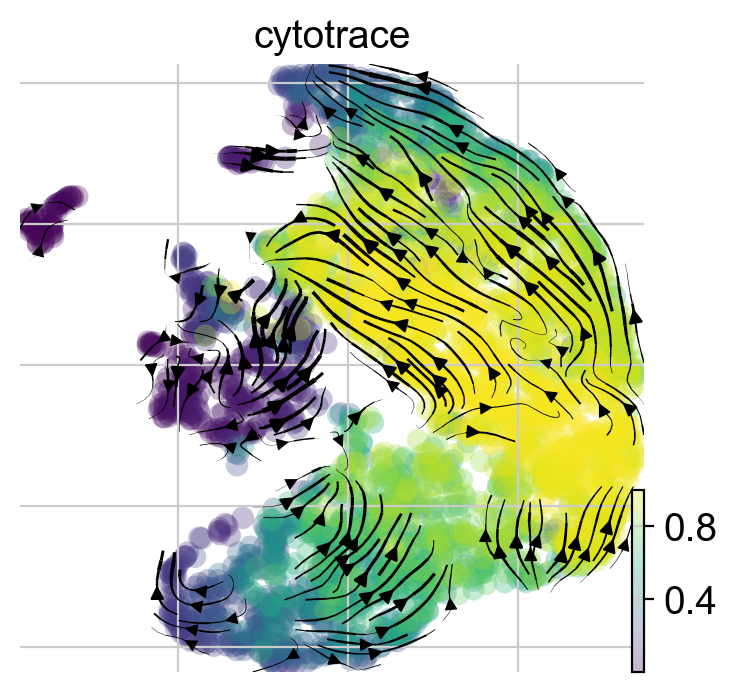

In [18]:
differentiation_figure = figures_dir_TE001 + name_prefix + "RNAVeloKernel_differentiation_ges_clusters.svg"
vk.plot_projection(basis="umap",
                    color="seurat_clusters.ges", 
                    legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE001 + name_prefix + "RNAVeloKernel_differentiation_pa_clusters.svg"
vk.plot_projection(basis="umap",
                    color = "iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE001 + name_prefix + "RNAVeloKernel_differentiation_cytotrace.svg"
vk.plot_projection(basis="umap",
                    color="cytotrace", 
                    legend_loc="right", save=differentiation_figure, show=True)

In [19]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [20]:
np.array(vk.transition_matrix) == np.array(ck.transition_matrix)

/var/folders/l_/wl8wsy81535frxdvqj0ltm280000gn/T/ipykernel_42172/1049006812.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.array(vk.transition_matrix) == np.array(ck.transition_matrix)


False

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_ConnectivityKernel_differentiation_ges_clusters.svg


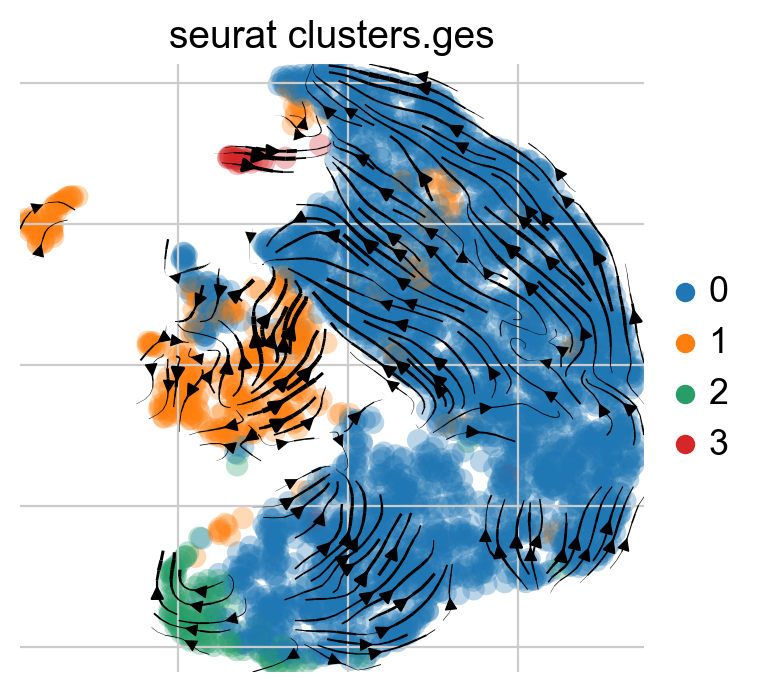

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_ConnectivityKernel_differentiation_pa_clusters.svg


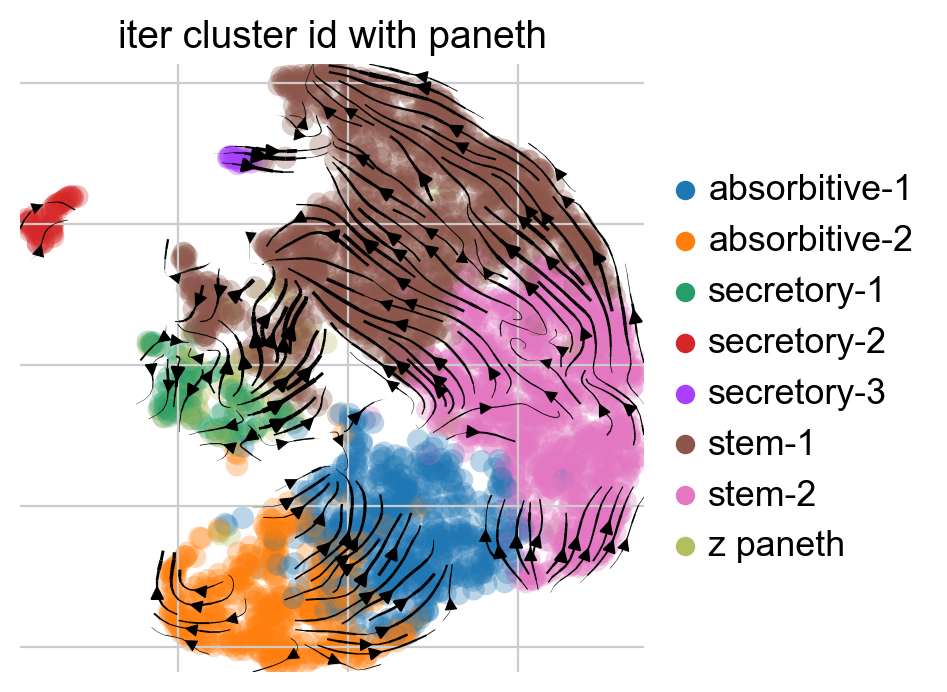

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_ConnectivityKernel_differentiation_cytotrace.svg


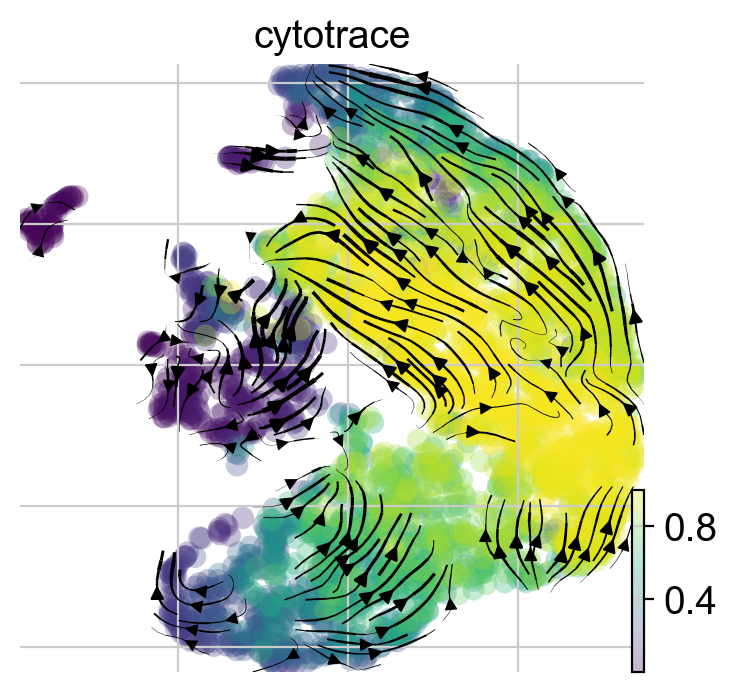

In [21]:
differentiation_figure = figures_dir_TE001 + name_prefix + "ConnectivityKernel_differentiation_ges_clusters.svg"
ck.plot_projection(basis="umap",
                   color="seurat_clusters.ges", 
                   legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE001 + name_prefix + "ConnectivityKernel_differentiation_pa_clusters.svg"
ck.plot_projection(basis="umap",
                   color = "iter_cluster_id_with_paneth", 
                   legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE001 + name_prefix + "ConnectivityKernel_differentiation_cytotrace.svg"
ck.plot_projection(basis="umap",
                   color="cytotrace", 
                   legend_loc="right", save=differentiation_figure, show=True)

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_CombinedKernel_differentiation_ges_clusters.svg


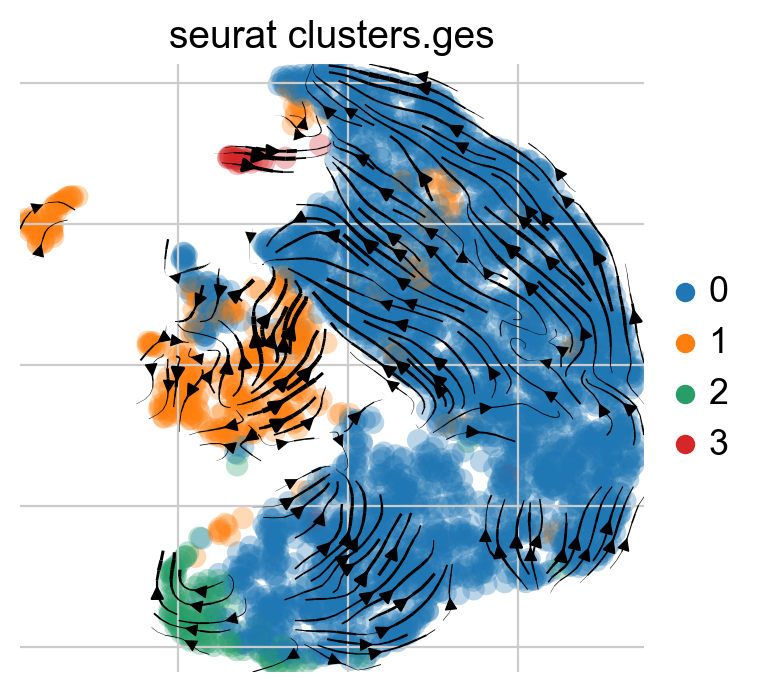

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_CombinedKernel_differentiation_pa_clusters.svg


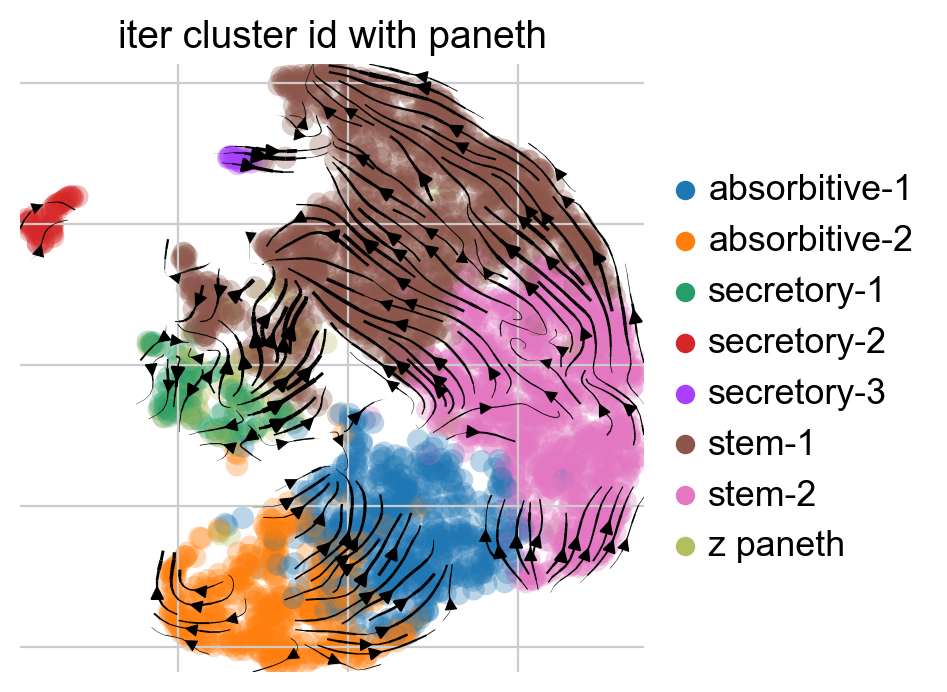

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_CombinedKernel_differentiation_cytotrace.svg


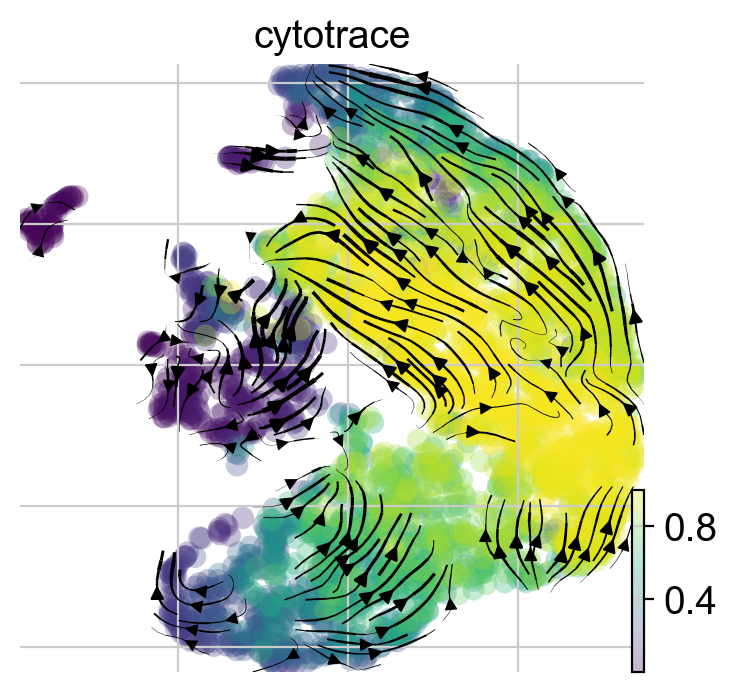

In [22]:
differentiation_figure = figures_dir_TE001 + name_prefix + "CombinedKernel_differentiation_ges_clusters.svg"
combined_kernel.plot_projection(basis="umap",
                    color="seurat_clusters.ges", 
                    legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE001 + name_prefix + "CombinedKernel_differentiation_pa_clusters.svg"
combined_kernel.plot_projection(basis="umap",
                    color = "iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE001 + name_prefix + "CombinedKernel_differentiation_cytotrace.svg"
combined_kernel.plot_projection(basis="umap",
                    color="cytotrace", 
                    legend_loc="right", save=differentiation_figure, show=True)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 9, 11, 13, 15, 17, 21]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:36)


/Users/AlexanderWang/opt/miniconda3/envs/cellrank_env_py3_10_osx_arm64/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


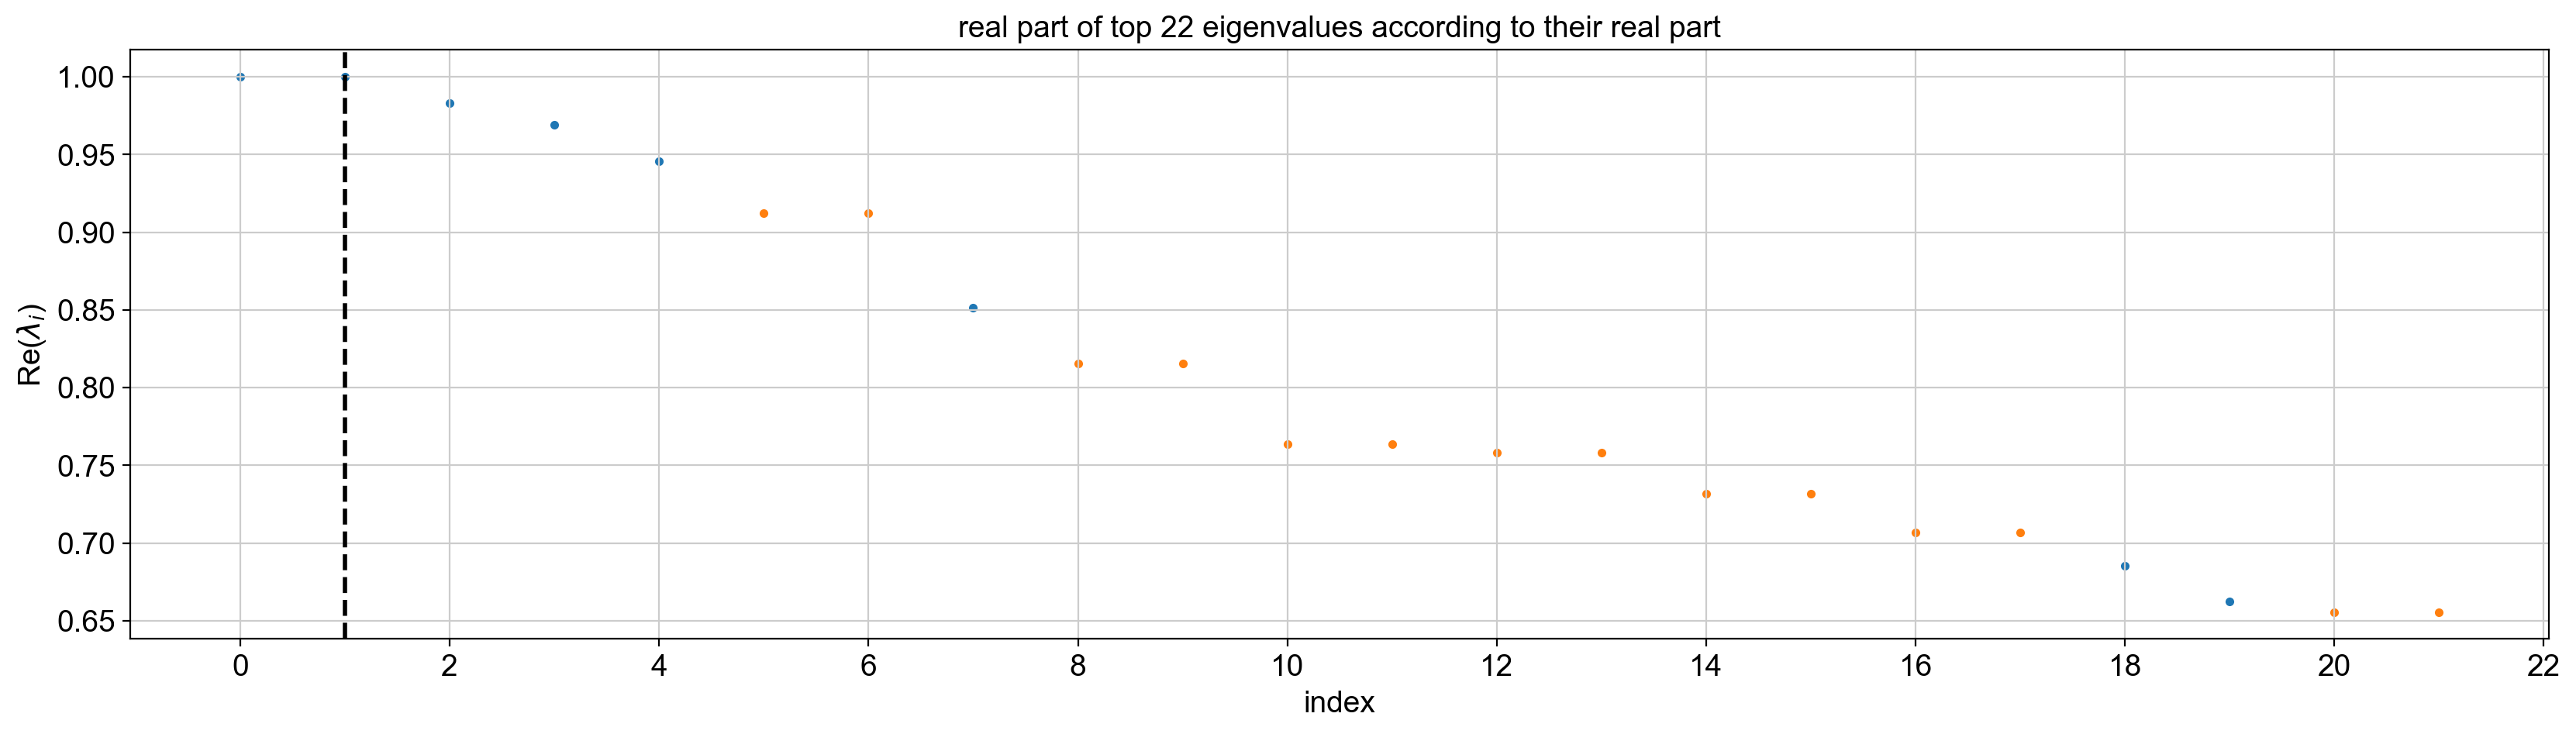

In [23]:
from cellrank.estimators import GPCCA
# d.1) compute estimator
g_vk = cr.estimators.GPCCA(vk)
g_vk.compute_schur(n_components=21) # compute Schur decomposition
eig_figure = figures_dir_TE001 + name_prefix + "GPCCA_eig.pdf"
g_vk.plot_spectrum(real_only=True, n=None, show_all_xticks=False, save=eig_figure, figsize=(20,5))

Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_GPCCA_macrostates.pdf


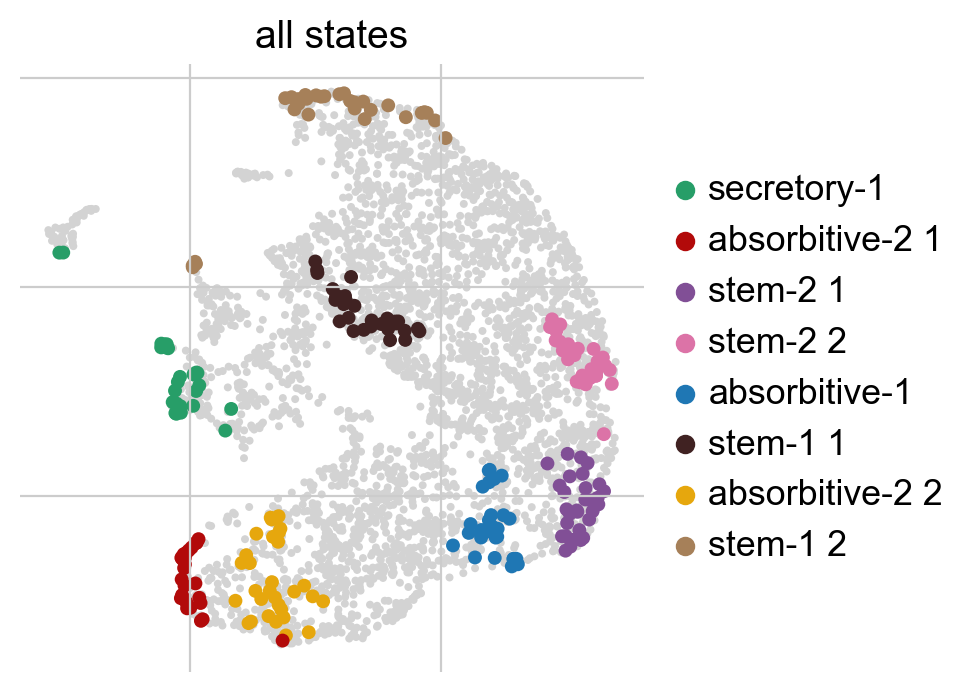

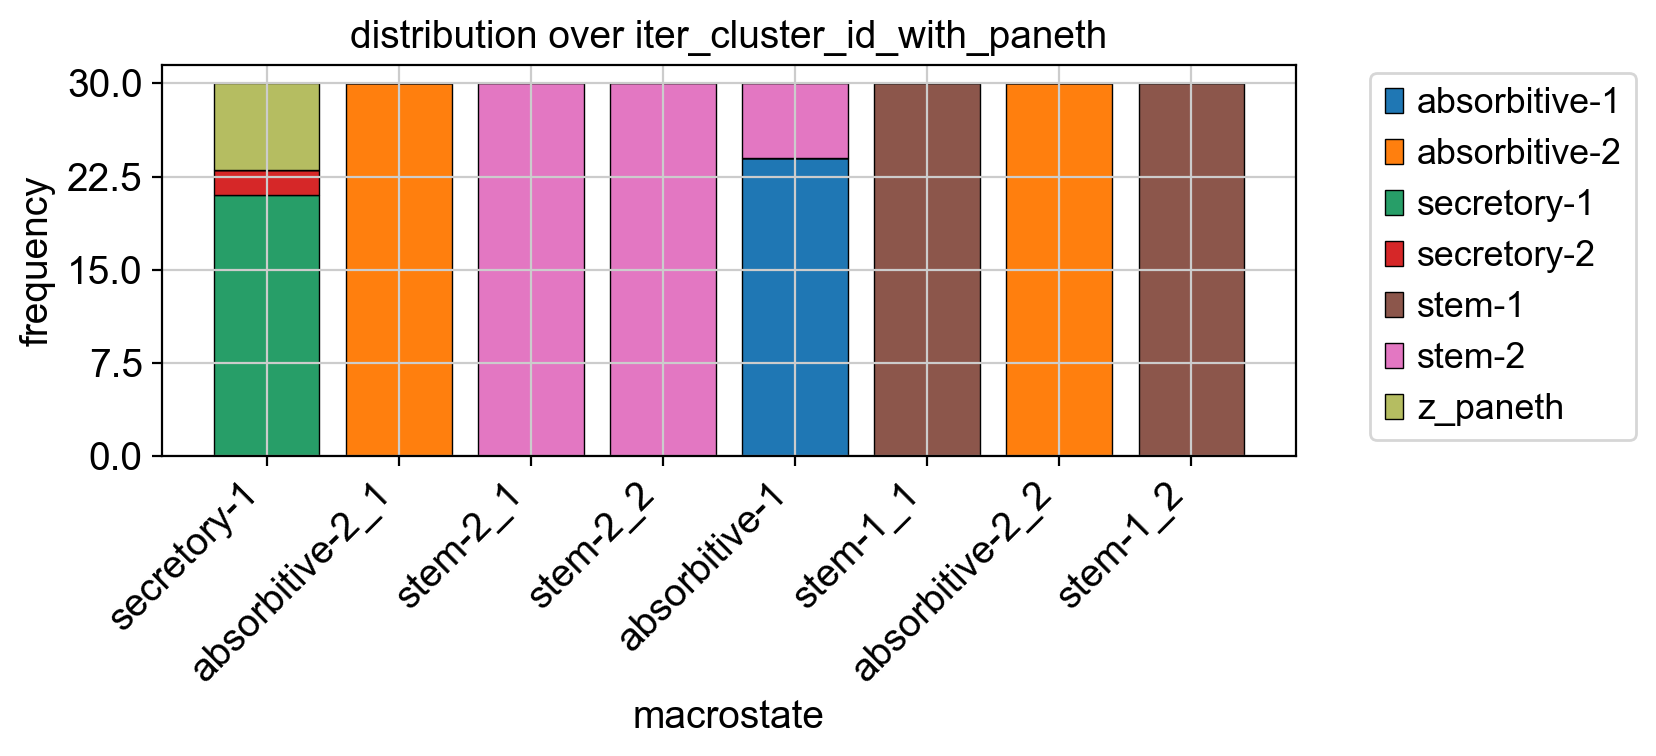

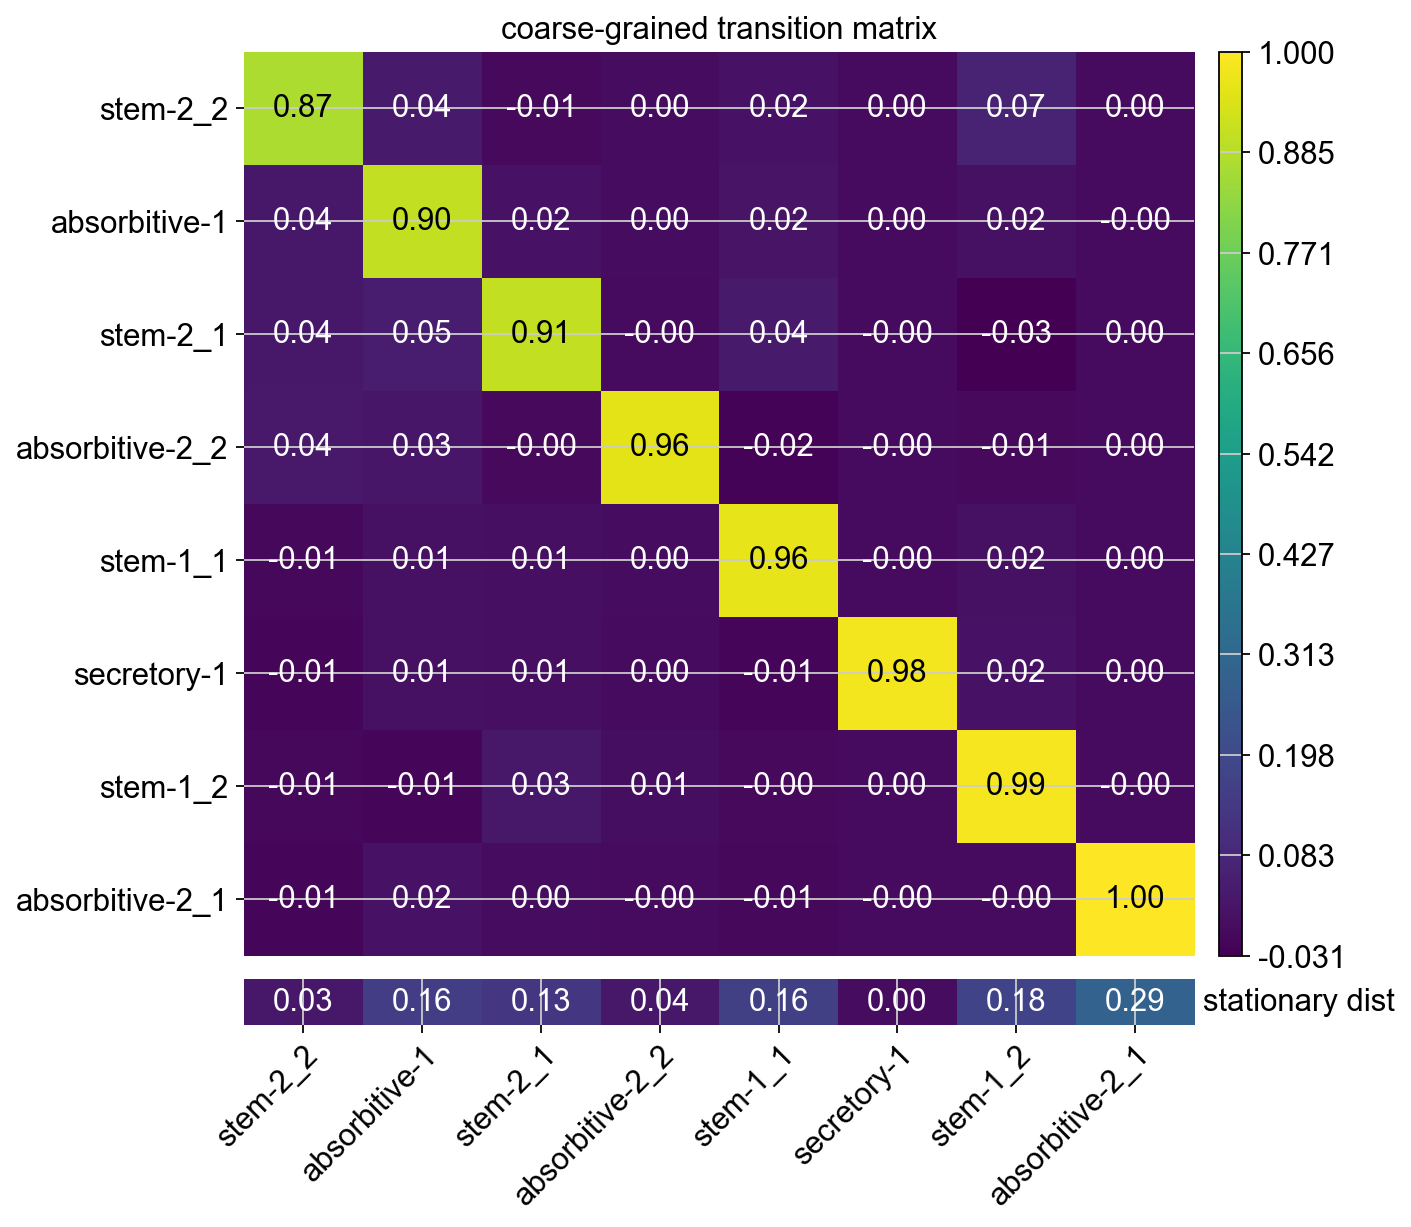

In [24]:
g_vk.compute_macrostates(n_states=8, cluster_key="iter_cluster_id_with_paneth")
macrostates_figure = figures_dir_TE001 + name_prefix + "GPCCA_macrostates.pdf"
g_vk.plot_macrostates(which="all", legend_loc="right", s=100, save=macrostates_figure, show=True)

macrostates_figure_composition = figures_dir_TE001 + name_prefix + "GPCCA_macrostates_composition.pdf"
g_vk.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=True, save=macrostates_figure_composition) # composition of each macrostate

coarse_T_figure = figures_dir_TE001 + name_prefix + "GPCCA_coarse_T.pdf"
g_vk.plot_coarse_T(annotate=True, save=coarse_T_figure) # plot transition matrix

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_GPCCA_initial_states.pdf


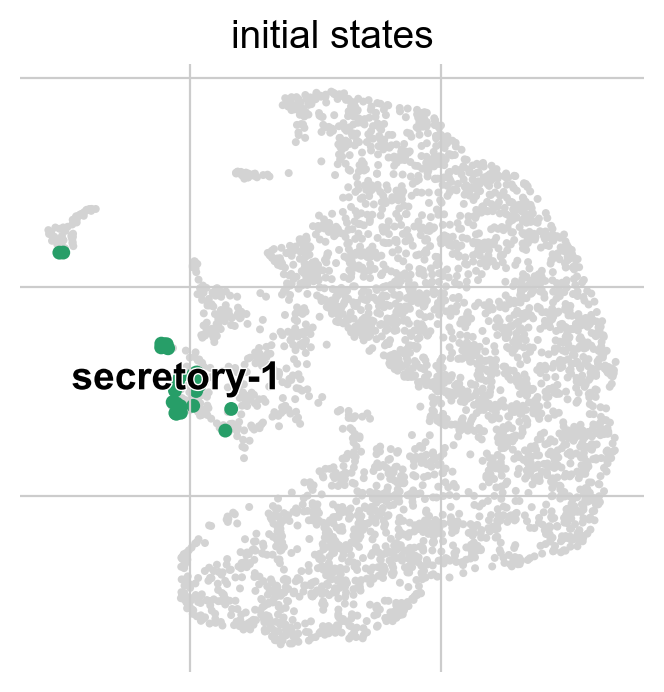

In [25]:
# d.3) predict initial states
g_vk.predict_initial_states(allow_overlap=True)
initial_states_figure = figures_dir_TE001 + name_prefix + "GPCCA_initial_states.pdf"
g_vk.plot_macrostates(which="initial", s=100, save =initial_states_figure, show = True)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE001/TE001_GPCCA_terminal_states.pdf


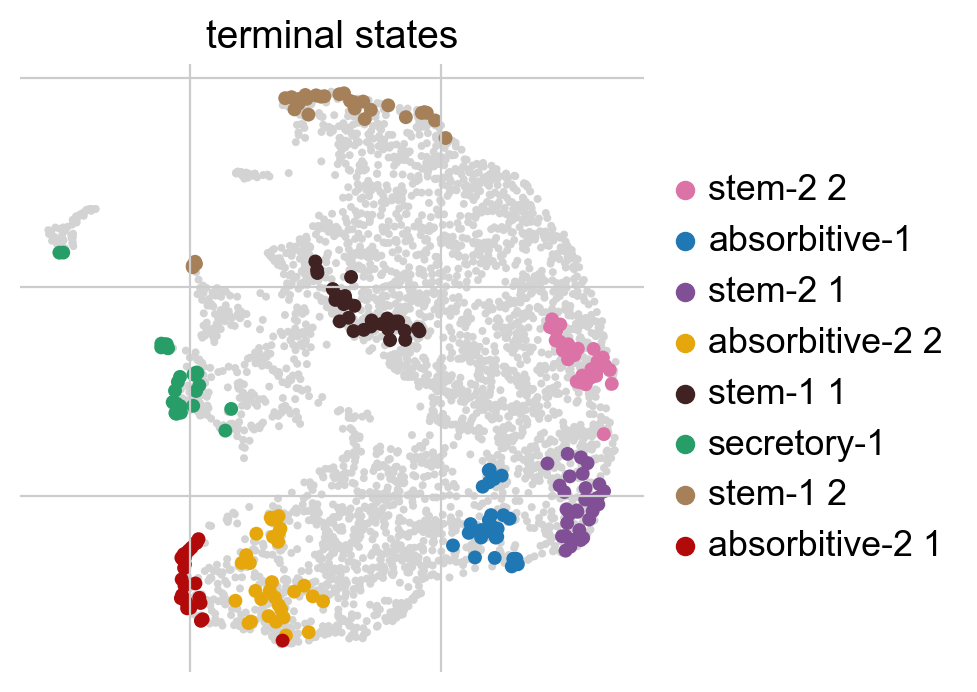

In [26]:
# d.2) compute terminal states
g_vk.predict_terminal_states(method = 'eigengap_coarse',allow_overlap = True)
terminal_states_figure = figures_dir_TE001 + name_prefix + "GPCCA_terminal_states.pdf"
g_vk.plot_macrostates(which="terminal", legend_loc="right", s=100, save=terminal_states_figure, show=True)

In [27]:
# d.2) compute terminal states
g_vk.predict_terminal_states()
terminal_states_figure = figures_dir_TE001 + name_prefix + "GPCCA_terminal_states.pdf"
g_vk.plot_macrostates(which="terminal", legend_loc="right", s=100, save=terminal_states_figure, show=True)

ValueError: Found `30` overlapping cells between initial and terminal states. If this is intended, please use `allow_overlap=True`.